Copyright (c) MONAI Consortium<br>
Licensed under the Apache License, Version 2.0 (the "License");<br>
you may not use this file except in compliance with the License.<br>
You may obtain a copy of the License at<br>
    http://www.apache.org/licenses/LICENSE-2.0<br>
Unless required by applicable law or agreed to in writing, software<br>
distributed under the License is distributed on an "AS IS" BASIS,<br>
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.<br>
See the License for the specific language governing permissions and<br>
limitations under the License.<br>

# 3D AutoencoderKL

This demo is a toy example of how to use MONAI's AutoencoderKL. In particular, it uses the Autoencoder with a Kullback-Leibler regularisation as implemented by Rombach et. al [1]. The autoencoder was originally implemented by Kingma et al. [2]. The model uses the 3D brain tumour segmentation challenge (BraTS) [3] dataset available as part of the Decathlon Dataset.

[1] Rombach et. al "High-Resolution Image Synthesis with Latent Diffusion Models" https://arxiv.org/pdf/2112.10752.pdf<br>
[2] Kingma, D. P., & Welling, M. (2014). Auto-Encoding Variational Bayes. CoRR, abs/1312.6.<br>
[3] Menze, B. H., Jakab, A., Bauer, S., Kalpathy-Cramer, J., Farahani, K., Kirby, J., Burren, Y., Porz, N., Slotboom, J., Wiest, R., Lanczi, L., Gerstner, E., Weber, M.-A., Arbel, T., Avants, B. B., Ayache, N., Buendia, P., Collins, D. L., Cordier, N., … van Leemput, K. (2015). The Multimodal Brain Tumor Image Segmentation Benchmark (BRATS). IEEE Transactions on Medical Imaging, 34(10), 1993–2024. https://doi.org/10.1109/TMI.2014.2377694<br>

This tutorial was based on:

[Brain tumor 3D segmentation with MONAI](https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/brats_segmentation_3d.ipynb)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm, nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [ ]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.networks.layers import Act
from monai.utils import first, set_determinism
from torch.amp import autocast
from monai.networks.nets import AutoencoderKL, PatchDiscriminator
from monai.losses import PatchAdversarialLoss, PerceptualLoss
from monai.utils.misc import ensure_tuple

print_config()

## Setup a data directory and download dataset

Specify a `MONAI_DATA_DIRECTORY` variable, where the data will be downloaded. If not specified a temporary directory will be used.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp0_29f8jr


## Set deterministic training for reproducibility

In [5]:
# for reproducibility purposes set a seed
set_determinism(42)

## Description of data, download the training set and creation of dataloaders

The brain tumour segmentation dataset is available as part of the Decathlon dataset. Select the channel (MRI contrast) you wish to use for training (0: FLAIR, 1: T1, 2: T1-PC, 3: T2). 
Note: The DecatholonDataset has 7GB. So make sure that you have enought space when running the next line

We use the following transforms:
1. `LoadImaged`: retrieve the nii image
2. `EnsureChannelFirstd`: we ensure that the channel component is in dimension 0 of the tensor
3. `Lambdad`: this custom transform retrieves the specific channel that we desire
4. `EnsureChannelFirstd`: we add the new channel dimension (as the last transform has removed it)

In [6]:
channel = 0  # 0 = Flair
assert channel in [0, 1, 2, 3], "Choose a valid channel"
all_transforms = [
    transforms.LoadImaged(keys=["image"]),
    transforms.EnsureChannelFirstd(keys=["image"]),
    transforms.Lambdad(keys="image", func=lambda x: x[channel, :, :, :]),
    transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
    transforms.EnsureTyped(keys=["image"]),
    transforms.Orientationd(keys=["image"], axcodes="RAS"),
    transforms.Spacingd(keys=["image"], pixdim=(2.4, 2.4, 2.2), mode=("bilinear")),
    transforms.CenterSpatialCropd(keys=["image"], roi_size=(96, 96, 64)),
    transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
]

In [24]:
# Training
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="training",
    cache_rate=1.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=True,
    seed=0,
    transform=transforms.Compose(all_transforms),
)
# Validation
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="validation",
    cache_rate=1.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=True,
    seed=0,
    transform=transforms.Compose(all_transforms),
)

Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:27<00:00,  3.47it/s]


Now we create the training and validation loaders:

In [25]:
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds[0]["image"].shape}')
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds[0]["image"].shape}')

Image shape torch.Size([1, 96, 96, 64])
Image shape torch.Size([1, 96, 96, 64])


## Visualise examples from the training set

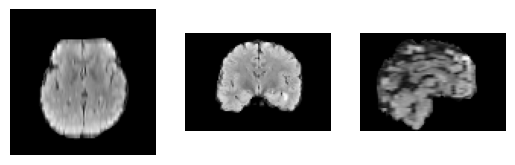

In [9]:
check_data = first(train_loader)
# Select the first image from the batch
img = check_data["image"][0]
fig, axs = plt.subplots(nrows=1, ncols=3)
for ax in axs:
    ax.axis("off")
ax = axs[0]
ax.imshow(img[0, ..., img.shape[3] // 2].rot90(), cmap="gray")
ax = axs[1]
ax.imshow(img[0, :, img.shape[2] // 2, ...].rot90(), cmap="gray")
ax = axs[2]
ax.imshow(img[0, img.shape[1] // 2, ...].rot90(), cmap="gray")

## Define the network

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [ ]:
model = AutoencoderKL(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(32, 64, 64),
    latent_channels=3,
    num_res_blocks=1,
    norm_num_groups=32,
    attention_levels=(False, False, True),
)
model.to(device)

Rombach et al. [1] trained the AutoencoderKL using a patch-GAN adversarial loss and perceptual loss to boost the quality of the reconstructed images.

In [ ]:
discriminator = PatchDiscriminator(
    spatial_dims=3,
    num_layers_d=3,
    channels=32,
    in_channels=1,
    out_channels=1,
    kernel_size=4,
    activation=(Act.LEAKYRELU, {"negative_slope": 0.2}),
    norm="BATCH",
    bias=False,
    padding=1,
)
discriminator.to(device)

In [ ]:
perceptual_loss = PerceptualLoss(spatial_dims=3, network_type="squeeze", fake_3d_ratio=0.25)
perceptual_loss.to(device)

## Definition of losses and optimisers

In [18]:
adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.02
perceptual_weight = 1.0
optimizer_g = torch.optim.Adam(model.parameters(), 1e-4)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=5e-4)

We also use automated mixed precision (AMP) to save memory:

In [15]:
scaler_g = torch.amp.GradScaler("cuda")
scaler_d = torch.amp.GradScaler("cuda")

## Model training

In [26]:
kl_weight = 1e-8
max_epochs = 50
val_interval = 5
print_every = 5
epoch_recon_loss_list = []
epoch_gen_loss_list = []
epoch_disc_loss_list = []
epoch_perc_loss_list = []
epoch_kl_loss_list = []
val_recon_epoch_loss_list = []
intermediary_images = []
n_example_images = 4

for epoch in range(max_epochs):
    model.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    kl_epoch_loss = 0
    perc_epoch_loss = 0
    for batch in train_loader:
        images = batch["image"].to(device)
        optimizer_g.zero_grad(set_to_none=True)

        # Generator part
        with autocast("cuda", enabled=True):
            reconstruction, z_mu, z_sigma = model(images)
            logits_fake = discriminator(reconstruction.contiguous().float())[-1]

            recons_loss = F.l1_loss(reconstruction.float(), images.float())
            p_loss = perceptual_loss(reconstruction.float(), images.float())
            generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)

            kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3, 4])
            kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]

            loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss) + (adv_weight * generator_loss)

        scaler_g.scale(loss_g).backward()
        scaler_g.step(optimizer_g)
        scaler_g.update()

        # Discriminator part
        optimizer_d.zero_grad(set_to_none=True)

        with autocast("cuda", enabled=True):
            logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
            loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
            logits_real = discriminator(images.contiguous().detach())[-1]
            loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
            discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

            loss_d = adv_weight * discriminator_loss

        scaler_d.scale(loss_d).backward()
        scaler_d.step(optimizer_d)
        scaler_d.update()

        epoch_loss += recons_loss.item()
        gen_epoch_loss += generator_loss.item()
        disc_epoch_loss += discriminator_loss.item()
        perc_epoch_loss += p_loss.item()
        kl_epoch_loss += kl_loss.item()

    epoch_recon_loss_list.append(epoch_loss / len(train_loader))
    epoch_gen_loss_list.append(gen_epoch_loss / len(train_loader))
    epoch_disc_loss_list.append(disc_epoch_loss / len(train_loader))
    epoch_perc_loss_list.append(perc_epoch_loss / len(train_loader))
    epoch_kl_loss_list.append(kl_epoch_loss / len(train_loader))

    if epoch % print_every == 0:
        msgs = [
            f"epoch {epoch:d}/{max_epochs:d}:",
            f"recons loss: {epoch_recon_loss_list[-1]:4f}, ",
            f"gen_loss: {epoch_gen_loss_list[-1]:4f}, ",
            f"disc_loss: {epoch_disc_loss_list[-1]:4f}, ",
            f"perc_loss: {epoch_perc_loss_list[-1]:4f}, ",
            f"kl_loss: {epoch_kl_loss_list[-1]:4f}, ",
        ]
        print("".join(msgs))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)
                optimizer_g.zero_grad(set_to_none=True)

                reconstruction, z_mu, z_sigma = model(images)
                # get the first sammple from the first validation batch for visualisation
                # purposes
                if val_step == 1:
                    intermediary_images.append(reconstruction[:n_example_images, 0])

                recons_loss = F.l1_loss(reconstruction.float(), images.float())

                val_loss += recons_loss.item()

        val_loss /= val_step
        val_recon_epoch_loss_list.append(val_loss)
        msgs = f"epoch {epoch:d}/{max_epochs:d}: validation recons loss: {val_recon_epoch_loss_list[-1]:4f}"
        print(msgs)

print("Training finished")

epoch 0/50:recons loss: 0.028408, gen_loss: 0.899995, disc_loss: 0.068511, perc_loss: 0.047966, kl_loss: 84008.107885, 
epoch 4/50: validation recons loss: 0.029058
epoch 5/50:recons loss: 0.026289, gen_loss: 0.890100, disc_loss: 0.075222, perc_loss: 0.044404, kl_loss: 82538.794358, 
epoch 9/50: validation recons loss: 0.031279
epoch 10/50:recons loss: 0.025868, gen_loss: 0.897919, disc_loss: 0.067960, perc_loss: 0.043630, kl_loss: 81820.101361, 
epoch 14/50: validation recons loss: 0.023571
epoch 15/50:recons loss: 0.027377, gen_loss: 0.953108, disc_loss: 0.047639, perc_loss: 0.044497, kl_loss: 80916.426989, 
epoch 19/50: validation recons loss: 0.026467
epoch 20/50:recons loss: 0.025950, gen_loss: 0.983597, disc_loss: 0.041265, perc_loss: 0.041636, kl_loss: 80244.706749, 
epoch 24/50: validation recons loss: 0.027087
epoch 25/50:recons loss: 0.024513, gen_loss: 1.003783, disc_loss: 0.033110, perc_loss: 0.040052, kl_loss: 81447.181137, 
epoch 29/50: validation recons loss: 0.027916
ep

## Evaluate the training

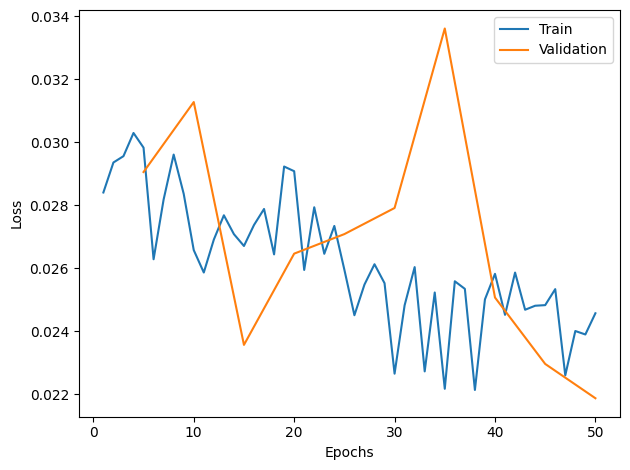

In [27]:
plt.figure()
val_samples = np.linspace(val_interval, max_epochs, int(max_epochs / val_interval))
plt.plot(np.linspace(1, max_epochs, max_epochs), epoch_recon_loss_list, label="Train")
plt.plot(val_samples, val_recon_epoch_loss_list, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

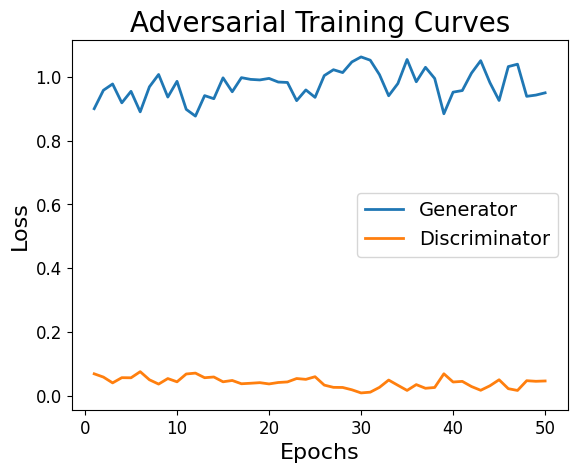

In [28]:
plt.title("Adversarial Training Curves", fontsize=20)
plt.plot(np.linspace(1, max_epochs, max_epochs), epoch_gen_loss_list, color="C0", linewidth=2.0, label="Generator")
plt.plot(np.linspace(1, max_epochs, max_epochs), epoch_disc_loss_list, color="C1", linewidth=2.0, label="Discriminator")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

### Visualise some reconstruction images

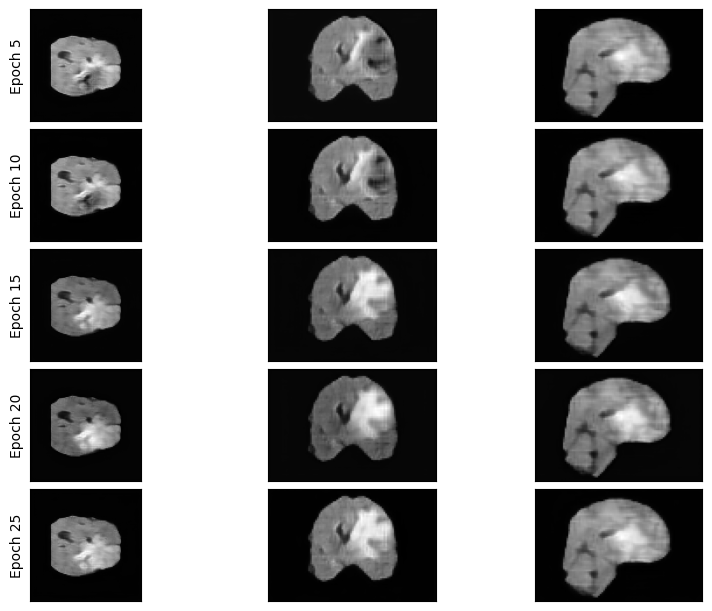

In [29]:
# get the first 5 examples to plot
n_evaluations = min(5, len(intermediary_images))

fig, axs = plt.subplots(nrows=n_evaluations, ncols=3, constrained_layout=True, figsize=(8, 6))
if axs.ndim == 1:
    axs = axs[None]

# Remove ticks
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

for image_n in range(n_evaluations):
    axs[image_n, 0].imshow(
        intermediary_images[image_n][0, ..., intermediary_images[image_n].shape[3] // 2].cpu(), cmap="gray"
    )
    axs[image_n, 1].imshow(
        intermediary_images[image_n][0, :, intermediary_images[image_n].shape[2] // 2, ...].cpu().rot90(), cmap="gray"
    )
    axs[image_n, 2].imshow(
        intermediary_images[image_n][0, intermediary_images[image_n].shape[1] // 2, ...].cpu().rot90(), cmap="gray"
    )
    axs[image_n, 0].set_ylabel(f"Epoch {val_samples[image_n]:.0f}")

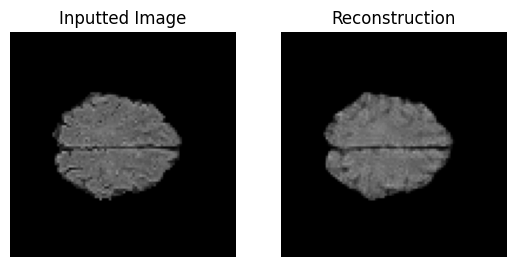

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax = ensure_tuple(ax)
ax[0].imshow(images[0, channel, ..., images.shape[2] // 2].cpu(), vmin=0, vmax=1, cmap="gray")
ax[0].axis("off")
ax[0].title.set_text("Inputted Image")
ax[1].imshow(reconstruction[0, channel, ..., reconstruction.shape[2] // 2].detach().cpu(), vmin=0, vmax=1, cmap="gray")
ax[1].axis("off")
ax[1].title.set_text("Reconstruction")
plt.show()

## Clean up data directory

Remove directory if a temporary storage was used

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)